In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsW_0256.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.84529143, 4.01459138)>


In [3]:
x = [101.839311,101.834507,101.755641,101.829614,101.810250,101.822584,101.744490,101.765208,101.735356,101.753151]
y = [03.929904,3.911874,3.933425,03.943406,3.939188,03.941496,04.009061,04.004846,3.993880,3.963151]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1I Reduced')
file1 = 'reduceducdW_0256.fits'
image1 = pf.getdata(file1)
file2 = 'reduceducdW_0257.fits'
image2 = pf.getdata(file2)
image = image1+image2

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[130.63433805 157.00504055 609.85955588 186.99630938 297.58818968
 227.12224665 678.39943466 559.53870532 729.74351687 625.96405187]
[588.45183415 692.43601955 572.90549095 511.33333828 536.68860478
 522.71696819 138.45364104 161.53998207 226.28841061 402.05412719]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
722 128.94278 587.40841 0.62711337 ...   0 946.82171 80.896283 -4.7698214
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
857 155.55723 690.59612 0.73999409 ...   0 689.55806 53.510801 -4.3211036
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
708 614.32484 574.84355 0.63424996 ...   0 9.8557077 1.1623605 -0.16335211
 id xcentroid ycentroid sharpness  ... sky    peak      flux     

In [8]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=4) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)
mags.remove(mags[2])
magserrors.remove(magserrors[2])

In [9]:
len(mags)

9

Beta: [  0.67505742 -19.94316918]
Beta Std Error: [0.03362705 0.47127832]
Beta Covariance: [[ 0.20260715 -2.83552744]
 [-2.83552744 39.79533521]]
Residual Variance: 0.005581137935716191
Inverse Condition #: 0.020452198154958776
Reason(s) for Halting:
  Sum of squares convergence


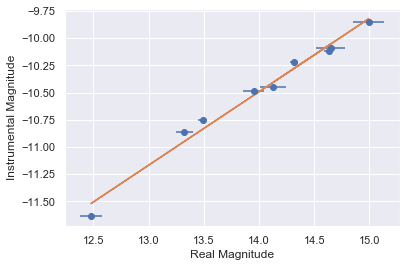

In [11]:
mags = np.array(mags)
Vmag = [14.909,15.313,15.289,14.459,13.321,14.072,14.495,15.924,15.427,14.909]
Vmag.remove(Vmag[2])
Vmag = np.array(Vmag)
Vmagerrors = [0.0032,0.0074,0.044,0.042,0.037,0.044,0.039,0.063,0.062,0.043]
Vmagerrors.remove(Vmagerrors[2])

rprime = [14.601,15.119,15.187,14.238,13.109,13.898,14.398,15.815,15.209,14.763]
rprime.remove(rprime[2])
rprimeerror = [0.032,0.085,0.087,0.066,0.042,0.048,0.095,0.0215,0.043,0.029]
rprimeerror.remove(rprimeerror[2])

iprime = [14.535,15.053,15.063,13.942,12.909,13.746,14.351,15.458,15.053,14.716]
iprime.remove(iprime[2])
iprimeerror = [0.098,0.111,0.157,0.032,0.083,0.064,0.074,0.118,0.034,0.029]
iprimeerror.remove(iprimeerror[2])

Imag = []
Imagerror = []
for rp, ip, rperror, iperror in zip(rprime,iprime,rprimeerror,iprimeerror):
    r = rp +0.035*(rp-ip-0.21)
    rdrp = 1.035
    rdip = -0.035
    rerror = np.sqrt((rdrp**2)*rperror**2+(rdip**2)*iperror**2)
    
    i = ip + 0.041*(rp-ip-0.21)
    idrp = 0.041
    idip = 0.959
    ierror = np.sqrt((idrp**2)*rperror**2+(idip**2)*iperror**2)
    
   
    I = r-1.2444*(r-i)-0.382
    dr = -0.2444
    di = -1.2444
    Ierror = np.sqrt((dr**2)*(rerror**2)+(di**2)*(ierror**2))
    
    Imag.append(I)
    Imagerror.append(Ierror)
Imag = np.array(Imag)
Imagerror = np.array(Imagerror)



plt.errorbar(Imag,mags,xerr=Imagerror,yerr=magserrors,fmt='o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(Imag, mags, sx = Imagerror, sy = None)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*Imag+myoutput.beta[1]
plt.plot(Imag,y)
myoutput.pprint()

In [12]:
xref = 419
yref = 376

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
484 624.53773 401.35021 0.76800451 ...   0 809.65348 60.239317 -4.4497001
449  418.4447 376.42677 0.57420632 ...   0 63495.205 5792.4225 -9.4071506


In [13]:
sourcemag = []
sourcemagerror = []
position = [(418.4447,376.42677)]
aperture = CircularAperture(position[0], r=4) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append(np.sqrt(((-1.08574/phot_table['aperture_sum_0'][0])**2)*(np.sqrt(phot_table['aperture_sum_0'][0])**2)))
print(sourcemag)

[-14.709962776597628]


In [14]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

7.752238960184977 +/- 0.7978188165638563
